In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR


In [3]:
train_data_dir = 'category_train'
categories = os.listdir(train_data_dir)
print(categories)

['Dress', 'Jacket', 'Jeans', 'Shoes', 'Sweater', 'T-shirt']


In [4]:
num_labels = len(categories)

category_to_label = {
    colour: idx for idx, colour in enumerate(categories)
}

label_to_category = {
    idx: colour for idx, colour in enumerate(categories)
}

print(num_labels)
print(category_to_label)
print(label_to_category)


6
{'Dress': 0, 'Jacket': 1, 'Jeans': 2, 'Shoes': 3, 'Sweater': 4, 'T-shirt': 5}
{0: 'Dress', 1: 'Jacket', 2: 'Jeans', 3: 'Shoes', 4: 'Sweater', 5: 'T-shirt'}


In [5]:
def random_pick() -> tuple[np.ndarray, int]:
    category = random.choice(categories)
    img_fnames = os.listdir(f'{train_data_dir}/{category}')
    img_path = f'{train_data_dir}/{category}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = category_to_label[category]
    return img, label

image_shape=(232, 148, 3)


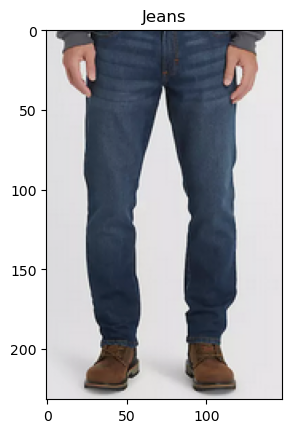

In [6]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_category[label])
plt.show()

In [7]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
# create a class to preload the images and transform for pytorch processing

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((500, 500)), # resize it to a square of 224x224
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('RGB') # open image and convert to RGB
        t_img = self.transform(img) # transform the image defined above
        return t_img

In [9]:
class ImageDataset(Dataset):

    train_data_dir = 'category_train'

    def __init__ (self, image_loader):
        categories = os.listdir(self.train_data_dir)

        self.data = []

        for category in tqdm(categories):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{category}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{category}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = category_to_label[category]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [10]:
dataset = ImageDataset(ImageLoader())

100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


In [11]:
dataset[0][1].shape

torch.Size([3, 500, 500])

In [15]:
val_ratio = 0.1
test_size = 20

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest



In [16]:
len(dataset)

249

In [17]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 205, val: 24, test: 20


In [18]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = True)

In [19]:
import torch.nn as nn

In [20]:
class CategoryClassifier(nn.Module):
    def __init__(self):
        super(CategoryClassifier, self).__init__()
        
        # convolutional layer output size:
        # [(Input - Kernel Size + 2 * Padding)/Stride] + 1

        # MaxPooling Layer
        # [(Input - Kernel Size)/Stride] + 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6, stride=4, padding=1), # [(500 - 6 + 2 * 1) / 4] + 1 = 125
            nn.MaxPool2d(kernel_size=3, stride=2), # [(125 - 3) / 2] + 1 = 62
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=4, padding=3), # [(62 - 4 + 2 * 3) / 4] + 1 = 17
            nn.MaxPool2d(kernel_size=2, stride=3), # [(17 - 2) / 3] + 1 = 6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=1), # [(6 - 2 + 2 * 1) / 2] + 1 = 4
            nn.MaxPool2d(kernel_size=4, stride=1), # ([4 - 4) / 1] + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )


        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels),
            nn.ReLU(),
            nn.Dropout(0.3)
        )


        
    def forward(self, x):
        x = self.conv1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = self.conv3(x)
        #print(x.size())
        x = self.fc1(x)
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        x = self.fc3(x)
        #print(x.size())

        return x

In [21]:
model = CategoryClassifier().to(device)

In [22]:
from torchsummary import summary

summary(model, (3, 500, 500))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           6,976
         MaxPool2d-2           [-1, 64, 62, 62]               0
       BatchNorm2d-3           [-1, 64, 62, 62]             128
              ReLU-4           [-1, 64, 62, 62]               0
         Dropout2d-5           [-1, 64, 62, 62]               0
            Conv2d-6          [-1, 128, 17, 17]         131,200
         MaxPool2d-7            [-1, 128, 6, 6]               0
       BatchNorm2d-8            [-1, 128, 6, 6]             256
              ReLU-9            [-1, 128, 6, 6]               0
        Dropout2d-10            [-1, 128, 6, 6]               0
           Conv2d-11            [-1, 256, 4, 4]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [23]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.007)


In [24]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_accuracy = corrects / total
    
    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()
    
    val_loss /= len(data_loader)
    val_accuracy = corrects / total   
    
    return val_loss, val_accuracy

In [25]:
epochs = 100

#scheduler = StepLR(optimizer, step_size = 75, gamma = 0.1) # decrease epoch by 0.1 every 75 steps

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, validation_loader)

    #scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


epoch=1, train_loss=1.797, val_loss=1.790, train_accuracy=0.215, val_accuracy=0.208


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


epoch=2, train_loss=1.789, val_loss=1.795, train_accuracy=0.161, val_accuracy=0.167


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


epoch=3, train_loss=1.782, val_loss=1.785, train_accuracy=0.220, val_accuracy=0.167


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


epoch=4, train_loss=1.776, val_loss=1.774, train_accuracy=0.220, val_accuracy=0.208


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


epoch=5, train_loss=1.776, val_loss=1.769, train_accuracy=0.210, val_accuracy=0.167


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


epoch=6, train_loss=1.751, val_loss=1.757, train_accuracy=0.205, val_accuracy=0.208


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


epoch=7, train_loss=1.712, val_loss=1.734, train_accuracy=0.234, val_accuracy=0.208


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


epoch=8, train_loss=1.759, val_loss=1.700, train_accuracy=0.283, val_accuracy=0.208


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


epoch=9, train_loss=1.747, val_loss=1.690, train_accuracy=0.273, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


epoch=10, train_loss=1.706, val_loss=1.697, train_accuracy=0.278, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


epoch=11, train_loss=1.659, val_loss=1.671, train_accuracy=0.302, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


epoch=12, train_loss=1.720, val_loss=1.642, train_accuracy=0.244, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


epoch=13, train_loss=1.613, val_loss=1.650, train_accuracy=0.293, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


epoch=14, train_loss=1.657, val_loss=1.630, train_accuracy=0.307, val_accuracy=0.292


100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


epoch=15, train_loss=1.673, val_loss=1.641, train_accuracy=0.293, val_accuracy=0.417


100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


epoch=16, train_loss=1.705, val_loss=1.668, train_accuracy=0.273, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


epoch=17, train_loss=1.661, val_loss=1.694, train_accuracy=0.263, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


epoch=18, train_loss=1.588, val_loss=1.755, train_accuracy=0.327, val_accuracy=0.208


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


epoch=19, train_loss=1.661, val_loss=1.686, train_accuracy=0.312, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


epoch=20, train_loss=1.583, val_loss=1.590, train_accuracy=0.268, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


epoch=21, train_loss=1.649, val_loss=1.586, train_accuracy=0.307, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


epoch=22, train_loss=1.566, val_loss=1.662, train_accuracy=0.346, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


epoch=23, train_loss=1.580, val_loss=1.685, train_accuracy=0.302, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


epoch=24, train_loss=1.521, val_loss=1.630, train_accuracy=0.351, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


epoch=25, train_loss=1.553, val_loss=1.625, train_accuracy=0.312, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


epoch=26, train_loss=1.572, val_loss=1.648, train_accuracy=0.346, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


epoch=27, train_loss=1.512, val_loss=1.654, train_accuracy=0.366, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


epoch=28, train_loss=1.519, val_loss=1.625, train_accuracy=0.327, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


epoch=29, train_loss=1.570, val_loss=1.654, train_accuracy=0.312, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


epoch=30, train_loss=1.557, val_loss=1.675, train_accuracy=0.327, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


epoch=31, train_loss=1.393, val_loss=1.671, train_accuracy=0.371, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


epoch=32, train_loss=1.607, val_loss=1.676, train_accuracy=0.341, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


epoch=33, train_loss=1.345, val_loss=1.633, train_accuracy=0.420, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


epoch=34, train_loss=1.510, val_loss=1.600, train_accuracy=0.351, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


epoch=35, train_loss=1.432, val_loss=1.570, train_accuracy=0.337, val_accuracy=0.458


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


epoch=36, train_loss=1.495, val_loss=1.563, train_accuracy=0.361, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


epoch=37, train_loss=1.531, val_loss=1.527, train_accuracy=0.346, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


epoch=38, train_loss=1.367, val_loss=1.588, train_accuracy=0.361, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


epoch=39, train_loss=1.333, val_loss=1.633, train_accuracy=0.400, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


epoch=40, train_loss=1.343, val_loss=1.602, train_accuracy=0.415, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


epoch=41, train_loss=1.369, val_loss=1.606, train_accuracy=0.366, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


epoch=42, train_loss=1.342, val_loss=1.660, train_accuracy=0.380, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


epoch=43, train_loss=1.444, val_loss=1.676, train_accuracy=0.380, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


epoch=44, train_loss=1.354, val_loss=1.618, train_accuracy=0.351, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


epoch=45, train_loss=1.286, val_loss=1.593, train_accuracy=0.405, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


epoch=46, train_loss=1.246, val_loss=1.520, train_accuracy=0.371, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


epoch=47, train_loss=1.439, val_loss=1.574, train_accuracy=0.366, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


epoch=48, train_loss=1.308, val_loss=1.594, train_accuracy=0.405, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


epoch=49, train_loss=1.424, val_loss=1.666, train_accuracy=0.351, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


epoch=50, train_loss=1.247, val_loss=1.701, train_accuracy=0.390, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


epoch=51, train_loss=1.303, val_loss=1.649, train_accuracy=0.380, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


epoch=52, train_loss=1.298, val_loss=1.671, train_accuracy=0.356, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


epoch=53, train_loss=1.327, val_loss=1.690, train_accuracy=0.400, val_accuracy=0.250


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


epoch=54, train_loss=1.375, val_loss=1.683, train_accuracy=0.385, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


epoch=55, train_loss=1.463, val_loss=1.643, train_accuracy=0.346, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


epoch=56, train_loss=1.279, val_loss=1.579, train_accuracy=0.395, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


epoch=57, train_loss=1.386, val_loss=1.605, train_accuracy=0.385, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


epoch=58, train_loss=1.307, val_loss=1.647, train_accuracy=0.366, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


epoch=59, train_loss=1.336, val_loss=1.655, train_accuracy=0.380, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


epoch=60, train_loss=1.397, val_loss=1.624, train_accuracy=0.371, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


epoch=61, train_loss=1.396, val_loss=1.626, train_accuracy=0.366, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


epoch=62, train_loss=1.354, val_loss=1.597, train_accuracy=0.390, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


epoch=63, train_loss=1.345, val_loss=1.526, train_accuracy=0.410, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


epoch=64, train_loss=1.323, val_loss=1.505, train_accuracy=0.361, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


epoch=65, train_loss=1.398, val_loss=1.510, train_accuracy=0.346, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


epoch=66, train_loss=1.395, val_loss=1.563, train_accuracy=0.366, val_accuracy=0.458


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


epoch=67, train_loss=1.379, val_loss=1.604, train_accuracy=0.366, val_accuracy=0.417


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


epoch=68, train_loss=1.358, val_loss=1.649, train_accuracy=0.356, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


epoch=69, train_loss=1.447, val_loss=1.690, train_accuracy=0.395, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


epoch=70, train_loss=1.281, val_loss=1.694, train_accuracy=0.400, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


epoch=71, train_loss=1.325, val_loss=1.658, train_accuracy=0.395, val_accuracy=0.250


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


epoch=72, train_loss=1.378, val_loss=1.582, train_accuracy=0.366, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


epoch=73, train_loss=1.327, val_loss=1.625, train_accuracy=0.390, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


epoch=74, train_loss=1.300, val_loss=1.655, train_accuracy=0.395, val_accuracy=0.250


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


epoch=75, train_loss=1.339, val_loss=1.675, train_accuracy=0.346, val_accuracy=0.250


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


epoch=76, train_loss=1.271, val_loss=1.671, train_accuracy=0.405, val_accuracy=0.250


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


epoch=77, train_loss=1.319, val_loss=1.661, train_accuracy=0.351, val_accuracy=0.250


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


epoch=78, train_loss=1.396, val_loss=1.669, train_accuracy=0.361, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


epoch=79, train_loss=1.364, val_loss=1.658, train_accuracy=0.356, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


epoch=80, train_loss=1.293, val_loss=1.589, train_accuracy=0.405, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


epoch=81, train_loss=1.291, val_loss=1.556, train_accuracy=0.361, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


epoch=82, train_loss=1.394, val_loss=1.522, train_accuracy=0.361, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


epoch=83, train_loss=1.218, val_loss=1.508, train_accuracy=0.400, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


epoch=84, train_loss=1.221, val_loss=1.533, train_accuracy=0.395, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


epoch=85, train_loss=1.453, val_loss=1.561, train_accuracy=0.420, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


epoch=86, train_loss=1.335, val_loss=1.611, train_accuracy=0.371, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


epoch=87, train_loss=1.386, val_loss=1.652, train_accuracy=0.371, val_accuracy=0.292


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


epoch=88, train_loss=1.407, val_loss=1.668, train_accuracy=0.395, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


epoch=89, train_loss=1.385, val_loss=1.699, train_accuracy=0.380, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


epoch=90, train_loss=1.386, val_loss=1.649, train_accuracy=0.376, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


epoch=91, train_loss=1.327, val_loss=1.644, train_accuracy=0.380, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


epoch=92, train_loss=1.265, val_loss=1.631, train_accuracy=0.390, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


epoch=93, train_loss=1.186, val_loss=1.578, train_accuracy=0.415, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


epoch=94, train_loss=1.310, val_loss=1.536, train_accuracy=0.376, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


epoch=95, train_loss=1.267, val_loss=1.517, train_accuracy=0.400, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


epoch=96, train_loss=1.360, val_loss=1.529, train_accuracy=0.405, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


epoch=97, train_loss=1.229, val_loss=1.521, train_accuracy=0.420, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


epoch=98, train_loss=1.260, val_loss=1.545, train_accuracy=0.405, val_accuracy=0.375


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


epoch=99, train_loss=1.203, val_loss=1.577, train_accuracy=0.410, val_accuracy=0.333


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

epoch=100, train_loss=1.351, val_loss=1.594, train_accuracy=0.376, val_accuracy=0.375


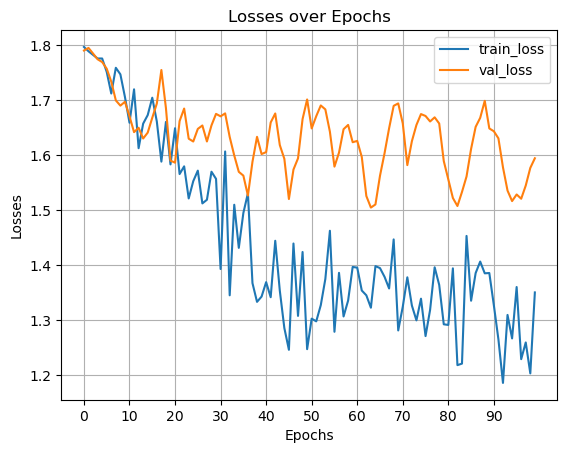

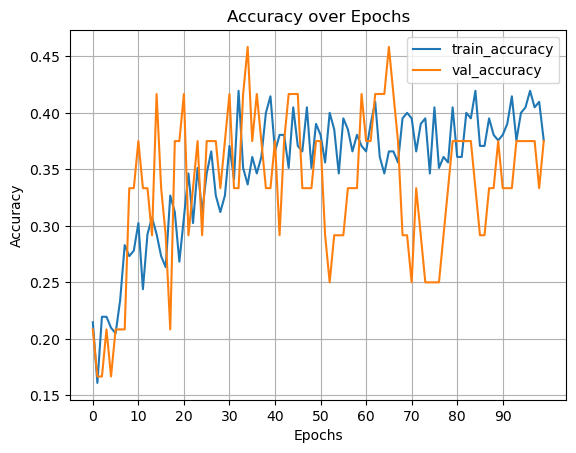

In [26]:
def plot_metrics(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(epochs), train_metric)
    plt.plot(range(epochs), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage for losses
plot_metrics(epochs, train_losses, val_losses, 'loss', 'Losses', 'Losses over Epochs')

# Example usage for accuracies
plot_metrics(epochs, train_accuracies, val_accuracies, 'accuracy', 'Accuracy', 'Accuracy over Epochs')

In [23]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(10))
sample_loader = DataLoader(sample_data, batch_size=30)

In [24]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    axes = np.reshape(axes, (math.ceil(len(img_paths) / 5), 5))  # Reshape axes array
    
    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
        
        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'Actual Category: {label_to_category[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f"Predicted {label_to_category[best_idx0]}: {outputs[i, best_idx0]*100:.2f}%\n"
        title += f"Predicted {label_to_category[best_idx1]}: {outputs[i, best_idx1]*100:.2f}%\n"
        axes[i // 5, i % 5].set_title(title)

    plt.show()

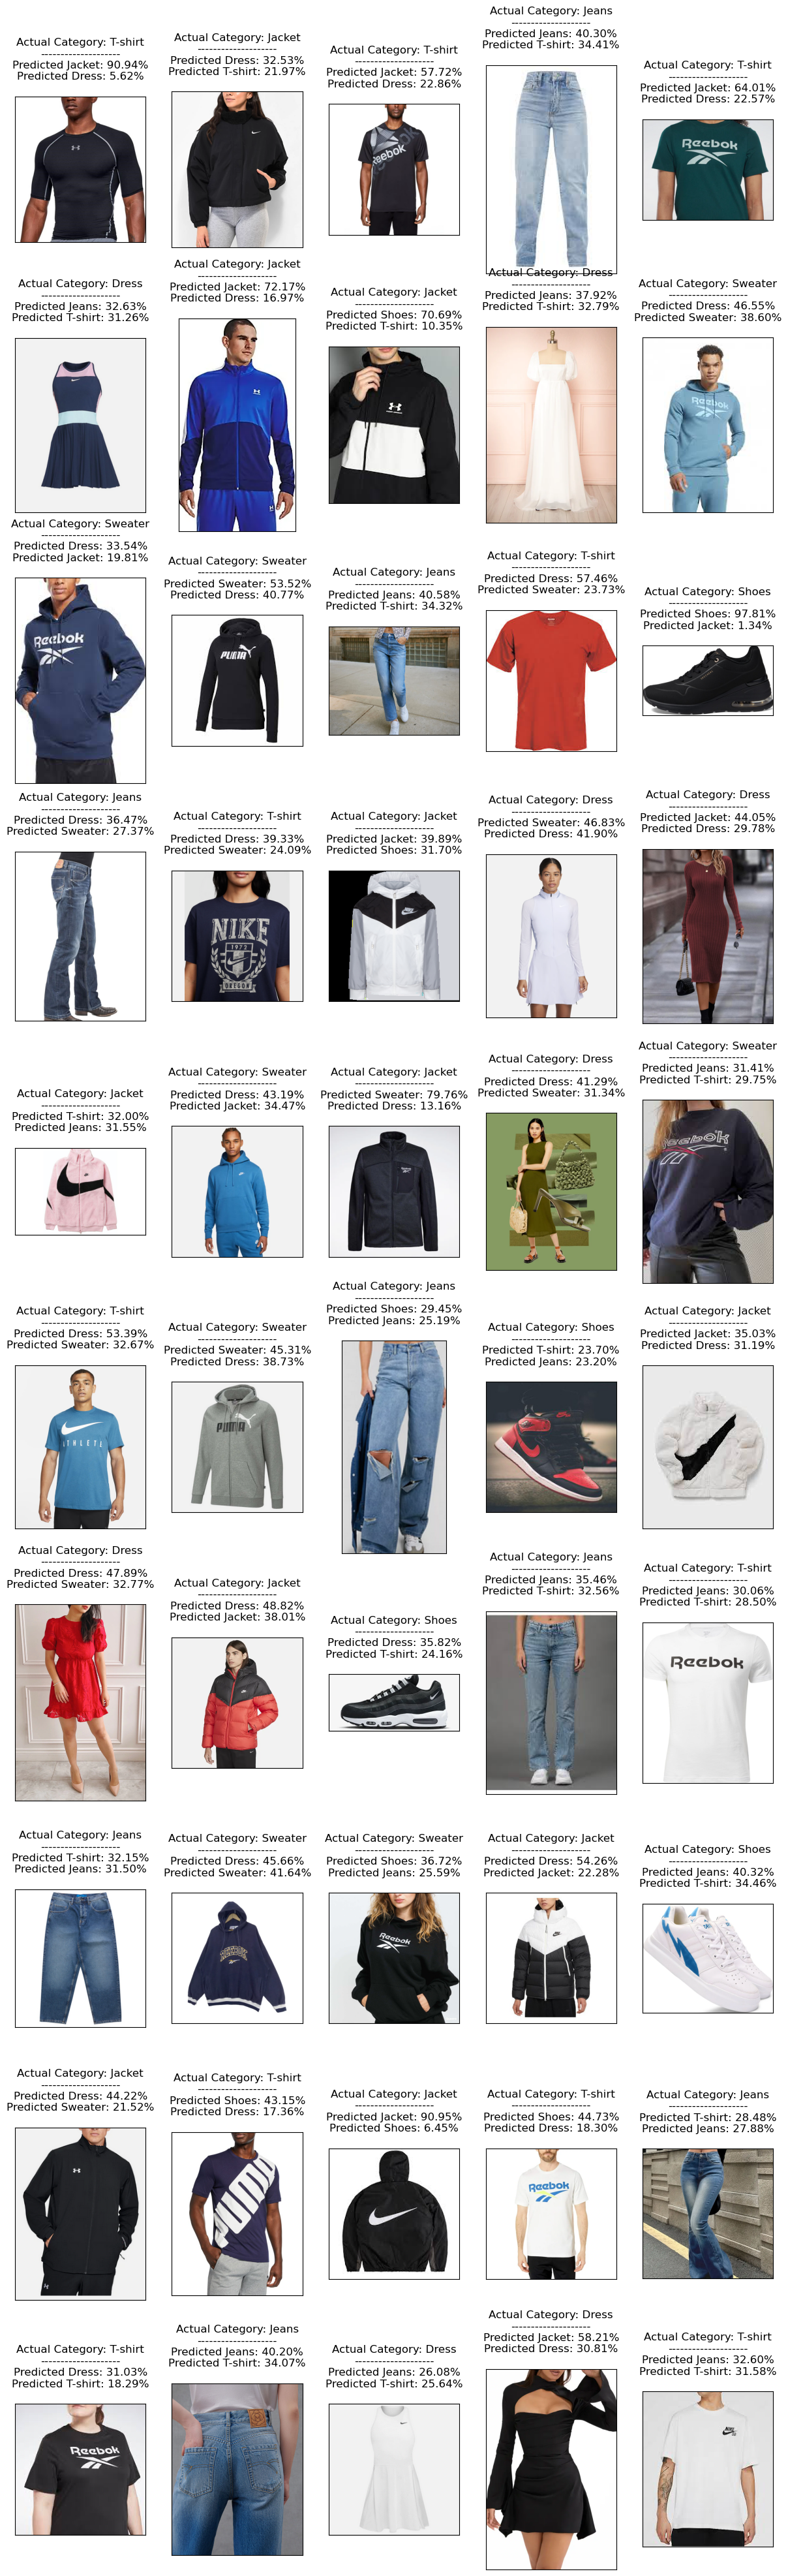

In [25]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)